In [1]:
import os
from force_lc import prepare_forced_phot, get_force_lightcurve, quicklook_mylc
from refine_lc import get_refined_lc
from compare_lc import plot_forcephot_lc

In [2]:
name = 'ZTF18aasdted'
targetdir = os.getcwd() + '/' + name + '/'

In [3]:
before_marshal_detection = None
detection_jd = None
recenter_coo = True
plot_mod = 20
ndays_before_peak = 15
ndays_after_peak = 40
open_check = False
prepare_forced_phot(name, targetdir = targetdir, 
                    before_marshal_detection = before_marshal_detection, 
                    detection_jd = detection_jd, recenter_coo = recenter_coo,
                    ndays_before_peak = ndays_before_peak, 
                    ndays_after_peak = ndays_after_peak,
                    open_check = open_check)



Start getting coordinate for ZTF18aasdted
ZTF18aasdted: ra=261.413161, dec=59.446771


Querying for metadata...
Trying to download 781 images from irsa...
In progress: 0 in 781
In progress: 30 in 781
In progress: 60 in 781
In progress: 90 in 781
In progress: 120 in 781
In progress: 150 in 781
In progress: 180 in 781
In progress: 210 in 781
In progress: 240 in 781
In progress: 270 in 781
In progress: 300 in 781
In progress: 330 in 781
In progress: 360 in 781
In progress: 390 in 781
In progress: 420 in 781
In progress: 450 in 781
In progress: 480 in 781
In progress: 510 in 781
In progress: 540 in 781
In progress: 570 in 781
In progress: 600 in 781
In progress: 630 in 781
In progress: 660 in 781
In progress: 690 in 781
In progress: 720 in 781
In progress: 750 in 781
In progress: 780 in 781
128 images in 781 we do not have data:
Determining the coordinate based on observations around peak...
Reading: 0 in 653...
Reading: 100 in 653...
Reading: 200 in 653...
Reading: 300 in 653...
Reading

/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

re-center: 10 in 208
re-center: 20 in 208
re-center: 30 in 208
re-center: 40 in 208
re-center: 50 in 208
re-center: 60 in 208
re-center: 70 in 208
re-center: 80 in 208
re-center: 90 in 208
re-center: 100 in 208
re-center: 110 in 208
re-center: 120 in 208
re-center: 130 in 208
re-center: 140 in 208
re-center: 150 in 208
re-center: 160 in 208
re-center: 170 in 208
re-center: 180 in 208
re-center: 190 in 208
re-center: 200 in 208
remove 0 images with bad pixels
remove 18 images with seeing > 3 arcsec
remove 22 images with 3-sigma clipping


In [4]:
r_psf = 3
r_bkg_in = 10
r_bkg_out = 15
manual_mask = False
col_mask_start = 0
col_mask_end = 0                 
row_mask_start = 0 
row_mask_end = 0
get_force_lightcurve(name, targetdir, r_psf = r_psf, plot_mod = plot_mod,
                     r_bkg_in = r_bkg_in, r_bkg_out = r_bkg_out,
                     manual_mask = manual_mask, 
                     col_mask_start = col_mask_start, col_mask_end = col_mask_end,                  
                     row_mask_start = row_mask_start, row_mask_end = row_mask_end)



Start fitting porced light curve for ZTF18aasdted...
In progress: 0 in 653...
In progress: 20 in 653...
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
In progress: 40 in 653...
In progress: 60 in 653...
In progress: 80 in 653...
In progress: 100 in 653...
In progress: 120 in 653...
In progress: 140 in 653...
In progress: 160 in 653...
In progress: 180 in 653...
In progress: 200 in 653...
In progress: 220 in 653...
In progress: 240 in 653...
In progress: 260 in 653...
In progress: 280 in 653...
In progress: 300 in 653...
In progress: 320 in 653...
In progress: 340 in 653...
In progress: 360 in 653...
In progress: 380 in 653...
In progress: 400 in 653...
In progress: 420 in 653...
In progress: 440 in 653...
In progress: 460 in 653...
In progress: 480 in 653...
In progress: 500 in 653...
In progress: 520 in 653...
Set status to False -- Bad pixel in the ce

# quick look, define the end of baseline jd

In [7]:
import matplotlib.pyplot as plt
quicklook_mylc(name, targetdir)
plt.close()

read light curves...
30 epochs among 737 deleted in marshal lightcurve based on seeing and ccd edge issues...
ploting chi 
perform baseline correction and uncertainty validation at the faint end...
plotting chi value at the baseline
median of chi is less than 1, do nothing, chi = 0.926
there is always an offset between magnitude from marshal and force photometry
we need to sclae one to the other to use unpublished public data...


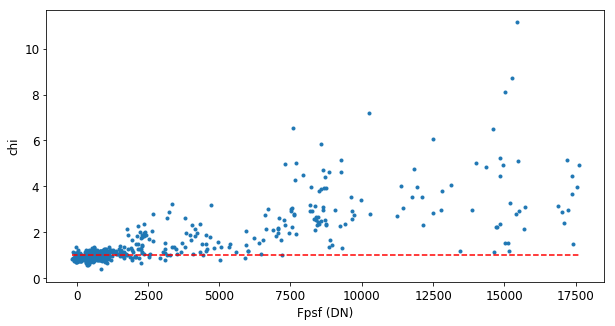

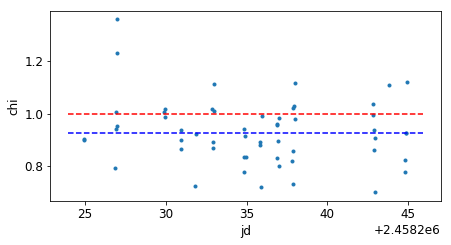

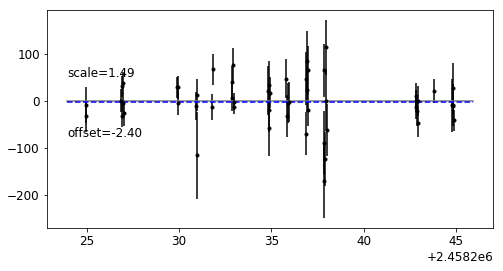

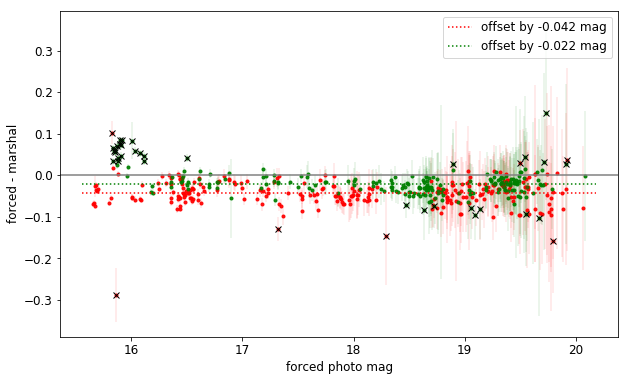

In [9]:
baseline_end = 2458245
seeing_cut = 3    
diff_sigma_cut = 2.5
get_refined_lc(name, targetdir, baseline_end = baseline_end, 
               seeing_cut = seeing_cut, diff_sigma_cut = diff_sigma_cut)
plt.close()
plt.close()

In [10]:
plot_forcephot_lc(name, targetdir)